# Node2Vec

Instead of obtaining sequences of nodes with a uniform distribution as in DeepWalk and random walks, the walks are biased to improve performance.

## Define a neighbourhood
Need to define nodes that are in the neighbourhood of the starting node. It is intuitive to do this using breadth first search, i.e. all the nodes that are connected to the starting node. However this can also be done using depth first search. DFS creates sequences of distant nodes. In practice a combination of both these searches are required to capture the network's properties:
* **Structural equivalence** - nodes a structurally equivalent if these share many of the same neighbours
* **Homophily** - similar nodes are more likely to be connected

## Biases in Random Walks
In Node2Vec, bias the randomness of the walks to promote either BFS or DFS

In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
random.seed(0)
np.random.seed(0)

In [3]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

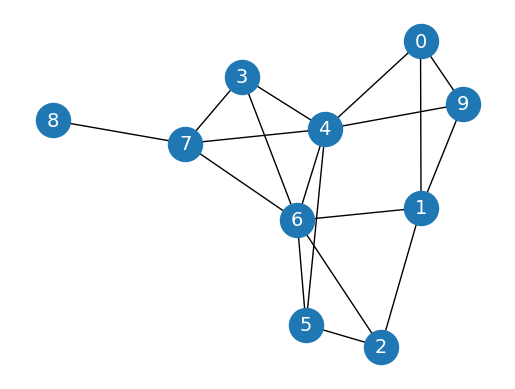

In [4]:
plt.figure()
plt.axis('off')
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=0),
    node_size=600,
    cmap='coolwarm',
    font_size=14,
    font_color='white'
)

The parameters `p` and `q` are used to bias the random walk. These parameters are set to promote whether the walk is biased back towards the previous node, forward towards a new node or other nodes that are adjacent to the previous node. When the parameter `p` is higher, the random walk will explore new nodes and tends towards a DFS. When the parameter `q` is higher, the random walk will focus on nodes that are close to the previous one and will resemble BFS.

In [5]:
def next_node(previous, current, p, q):
    neighbours = list(G.neighbors(current))
    alphas = []
    for n in neighbours:
        if n == previous:
            alpha = 1/p
        elif G.has_edge(n, previous):
            alpha = 1
        else:
            alpha = 1/ q
        alphas.append(alpha)
    
    probs = [alpha / sum(alphas) for alpha in alphas]

    next = np.random.choice(neighbours, size=1, p=probs)[0]

    return next

In [6]:
def random_walk(start, length, p, q):
    walk = [start]
    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)
    return [str(x) for x in walk]

In [7]:
# test using p=1 and q=1 which has no bias so is equivalent to DeepWalk
random_walk(0, 8, p=1, q=1)

['0', '4', '7', '6', '4', '5', '4', '5', '6']

In [8]:
# Biased back towards previous node
random_walk(0, 8, p=1, q=10)

['0', '9', '1', '9', '1', '9', '1', '0', '1']

In [9]:
# Biases towards new nodes
random_walk(0, 8, p=10, q=1)

['0', '1', '9', '4', '7', '8', '7', '4', '6']

## Example using Zachary's Karate Club

In [16]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Create a list of random walks
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10, 1, 1))

# Create and train Word2Vec for DeepWalk
node2vec = Word2Vec(
    walks,
    hs=1,   # Hierarchical softmax
    sg=1,   # Skip-gram
    vector_size=100,
    window=10,
    workers=2,
    min_count=1,
    seed=0
)
node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
train_mask_str = [str(x) for x in train_mask]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
test_mask_str = [str(x) for x in test_mask]
labels = np.array(labels)

# Train Node2Vec classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(node2vec.wv[train_mask_str], labels[train_mask])

# Evaluate accuracy
y_pred_train = clf.predict(node2vec.wv[train_mask_str])
y_pred = clf.predict(node2vec.wv[test_mask_str])
acc_train = accuracy_score(y_pred_train, labels[train_mask])
acc_test = accuracy_score(y_pred, labels[test_mask])
print(f'Node2Vec accuracy train = {acc_train*100:.2f}%')
print(f'Node2Vec accuracy test = {acc_test*100:.2f}%')

Node2Vec accuracy train = 100.00%
Node2Vec accuracy test = 95.45%


## RecSys

In [18]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd

In [19]:
url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [21]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [22]:
ratings.shape

(100000, 4)

In [24]:
movies = pd.read_csv('ml-100k/u.item', sep='|', usecols=range(2), names=['movie_id', 'title'], encoding='latin-1')
movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [25]:
movies.shape

(1682, 2)

In [27]:
# Only retain movies that users liked
ratings = ratings[ratings['rating'] >= 4]
ratings.shape

(55375, 4)

In [28]:
from collections import defaultdict

pairs = defaultdict(int)

In [32]:
for group in ratings.groupby('user_id'):
    user_movies = list(group[1]['movie_id'])
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1

In [33]:
pairs

defaultdict(int,
            {(61, 33): 4,
             (61, 160): 6,
             (61, 20): 4,
             (61, 202): 4,
             (61, 171): 6,
             (61, 265): 8,
             (61, 47): 5,
             (61, 222): 2,
             (61, 253): 1,
             (61, 113): 3,
             (61, 227): 3,
             (61, 90): 2,
             (61, 64): 10,
             (61, 228): 8,
             (61, 121): 4,
             (61, 114): 2,
             (61, 132): 9,
             (61, 134): 10,
             (61, 98): 13,
             (61, 186): 9,
             (61, 221): 5,
             (61, 84): 1,
             (61, 60): 18,
             (61, 177): 7,
             (61, 174): 12,
             (61, 82): 5,
             (61, 56): 12,
             (61, 80): 1,
             (61, 229): 2,
             (61, 235): 2,
             (61, 6): 2,
             (61, 206): 2,
             (61, 76): 1,
             (61, 72): 2,
             (61, 185): 11,
             (61, 96): 8,
             (61, 25

In [34]:
G = nx.Graph()

for (movie1, movie2), score in pairs.items():
    if score >= 20:
        G.add_edge(movie1, movie2, weight=score)

In [39]:
print(f'Nodes = {len(G.nodes)}')
print(f'Edges = {len(G.edges)}')

Nodes = 410
Edges = 14936


In [42]:
from node2vec import Node2Vec

In [43]:
node2vec = Node2Vec(
    G,
    dimensions=64,
    walk_length=20,
    num_walks=200,
    p=2,
    q=1,
    workers=1
)

Generating walks (CPU: 1): 100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


In [44]:
model = node2vec.fit(
    window=10,
    min_count=1, 
    batch_words=4
)

TypeError: Word2Vec.__init__() got an unexpected keyword argument 'size'

In [ ]:
def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f'{title}: {id[1]:.2f}')

recommend('Star Wars (1977)')